In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import numpy as np

In [21]:
BASE_PATH = Path("/scratch3/PALAEO-RA/daily_data/final")
STATION_FOLDERS = ["Bergen", "Alkmaar", "Leiden", "Haarlem",
                   "Utrecht", "Breda", "Vlissingen"]
NAME_SUBSTR = "_rr_"              # must appear in the filename


In [22]:
def read_sef_timeseries(filepath: Path) -> pd.Series:
    """
    Read a SEF file and return a Series
    indexed by datetime, with 'Value' as data.
    """

    # Find the line number of the header: "Year Month Day Hour Minute Period Value Meta"
    with filepath.open("r", encoding="utf-8") as fh:
        header_line = None
        for i, line in enumerate(fh):
            if line.strip().startswith("Year"):
                header_line = i
                break
        lines = fh.readlines()

    if header_line is None:
        raise ValueError(f"Could not find 'Year ...' header in {filepath}")


    # Read the table from that header line
    df = pd.read_csv(
        filepath,
        sep="\t",
        engine="python",
        skiprows=12,
    )

    # Build datetime index
    date_cols = ["Year", "Month", "Day"]

    df["time"] = pd.to_datetime(df[date_cols])

    df = df.set_index("time")

    if "Value" not in df.columns:
        raise ValueError(f"'Value' column not found in {filepath}")

    # Return just the Value series
    return df["Value"].sort_index()



In [23]:
# Collect all files
files = []
for folder in STATION_FOLDERS:
    subdir = BASE_PATH / folder
    if not subdir.is_dir():
        continue
    for f in subdir.iterdir():
        if f.is_file() and NAME_SUBSTR in f.name:
            files.append(f)

if not files:
    raise FileNotFoundError(
        f"No files with '{NAME_SUBSTR}' found in {BASE_PATH} "
        f"under folders {STATION_FOLDERS}"
    )


In [24]:
# calculate all series
rr_series = {}

for f in files:
    station_name = f.stem.split("_")[0] # before first underscore
    rr_series[station_name] = read_sef_timeseries(f)

# multiply utrecht155 by 10 to see
rr_series['Utrecht155*10'] = rr_series["Utrecht155"] * 10

# reorganize

In [29]:
# calculate max value in each series
rr_max = {name: series.max() for name, series in rr_series.items()}
rr_max

{'Bergen': 1518,
 'Alkmaar': 880,
 'Leiden': 704,
 'Haarlem': 440,
 'Utrecht155': 183.5,
 'Utrecht43': 1038,
 'Breda2': 1584,
 'Vlissingen2': 800,
 'Utrecht155*10': 1835.0}

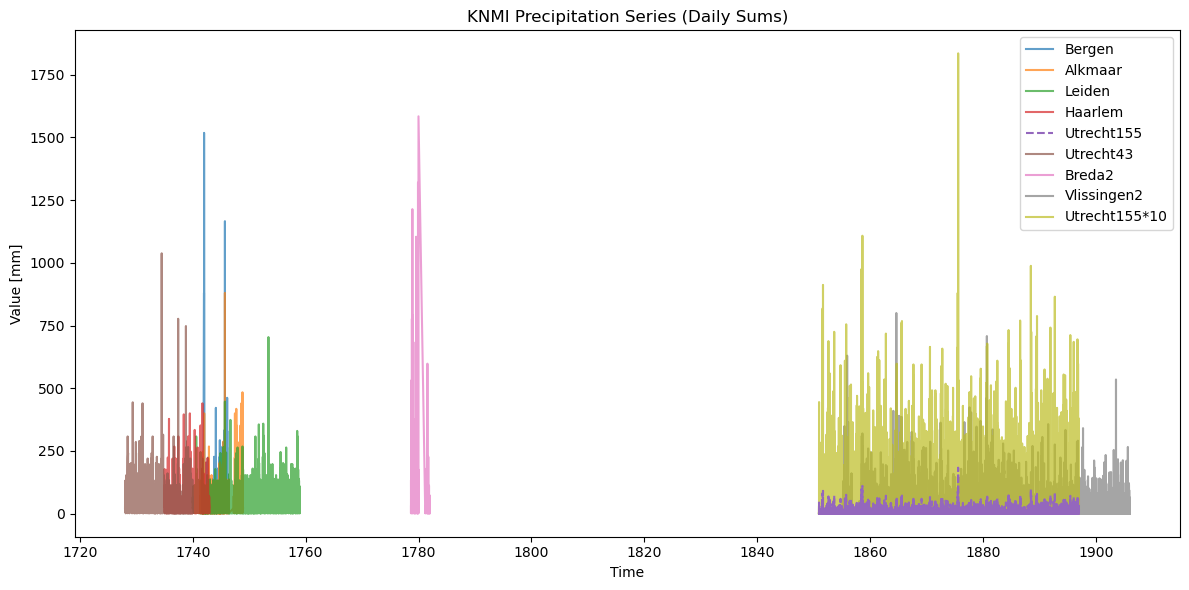

In [30]:
# Plot
plt.figure(figsize=(12, 6))

for station_name, series in rr_series.items():
    daily = series.resample("D").sum()
    if station_name == "Utrecht155":
        plt.plot(series.index, series.values, "--", label=station_name, zorder=3)
    else:
        plt.plot(series.index, series.values, label=station_name, alpha=.7)

plt.xlabel("Time")
plt.ylabel("Value [mm]")
plt.title("KNMI Precipitation Series (Daily Sums)")
plt.legend()
plt.tight_layout()
plt.savefig("../image/KNMI_rr_daily_series2.png", dpi=300)
plt.show()

## Histograms

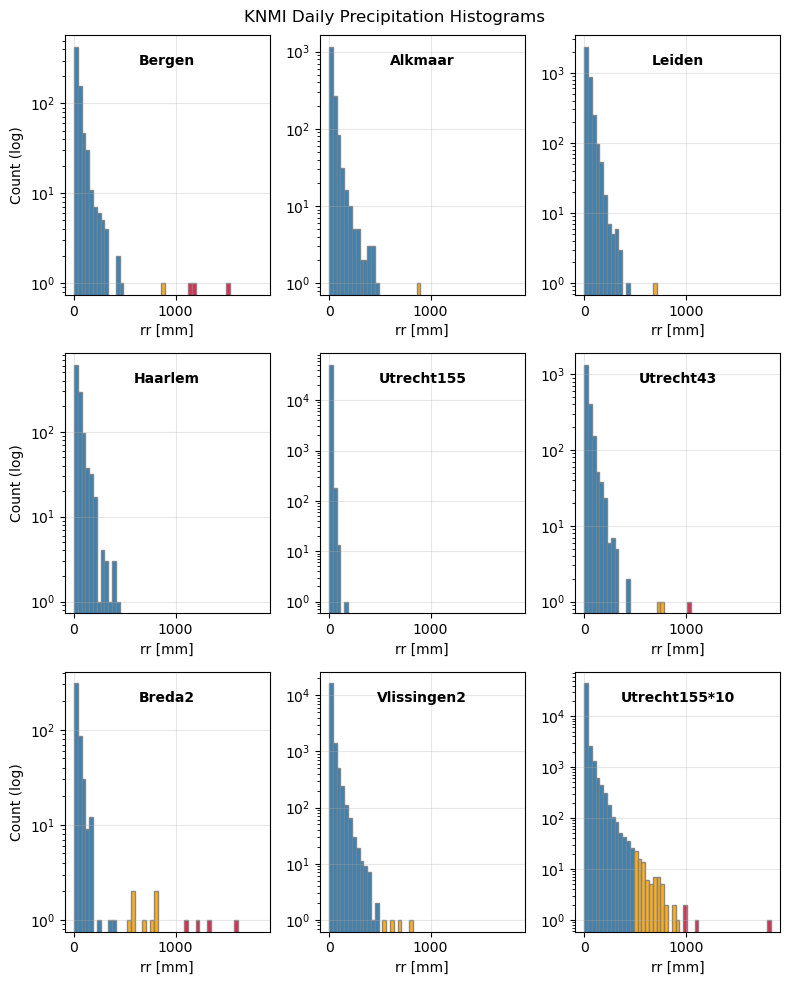

In [28]:
import math 
# determine common histogram bins
all_values = pd.concat(rr_series.values())
bins = np.linspace(0, all_values.max(), 50)

# Histograms
# create one subplot per station
n_stations = len(rr_series)
fig, axes = plt.subplots(math.ceil(n_stations/3), 3, figsize=(8, 10), sharey=False, sharex=True)

if n_stations == 1:
    axes = [axes]  # make it iterable

for ax in axes.flat:
    ax.tick_params(labelbottom=True)

for ax, (station_name, series) in zip(axes.flat[:len(rr_series)], rr_series.items()):
    
    
    counts, bin_edges = np.histogram(series.values, bins=bins)

    # determine color per bin (all counts for bins whose right edge >1000)
    colors = []
    for left, right in zip(bin_edges[:-1], bin_edges[1:]):
        if right > 1000:
            colors.append("crimson")          # >1000 mm
        elif right > 500:
            colors.append("orange")           # 500–1000 mm
        else:
            colors.append("C0")              # <500 mm

    # draw bars manually
    ax.bar(bin_edges[:-1], counts,
        width=np.diff(bin_edges),
        align='edge',
        color=colors,
        edgecolor='grey',
        alpha=0.9)

    # ax.hist(series.values, bins=bins, color='C0', alpha=0.7, edgecolor='grey')
    ax.grid(True, alpha=0.3)
    ax.text(0.5, 0.9, station_name,
        transform=ax.transAxes,
        ha='center', va='center',
        fontsize=10, fontweight='bold')

    ax.set_yscale('log')
    ax.set_xlabel("rr [mm]")

    # Get the index of this axis
    idx = list(axes.flat).index(ax)
    row, col = divmod(idx, 3)

    if col == 0:
        ax.set_ylabel("Count (log)")



# Clear leftover axes
for ax in axes.flat[len(rr_series):]:
    ax.axis("off")

plt.suptitle("KNMI Daily Precipitation Histograms")
plt.tight_layout()
plt.savefig("../image/KNMI_rr_histograms.png", dpi=300)
plt.show()